In [ ]:
# default_exp photon_data
%load_ext autoreload
%autoreload 2
from nbdev.showdoc import show_doc


# Manage the Parquet photon dataset
> Create monthly partitions

In [ ]:
#export
from astropy.io import fits
import healpy
import numpy as np
import pandas as pd

def convert_FT1( ft1_file,  
                etypes = (0,1),  
                theta_cut=66.4,  
                z_cut =100,
                ebins= np.logspace(2, 6, 17),
                nside=1024, nest=False,
                verbose=1):
        """
        Read in a photon data (FT1) file, bin in energy and position to convert to a compact DataFrame
        
        - ft1_file -- A monthly file generated by J. Ballet
        - etypes
        
        For the selected events above 100 MeV,  lists of the times and healpix ids
        (Reducing size from 27 to 9 bytes per photon)
        
        Returns: 

        - tstart, the start MET time,  and

        - DataFrame with dtype [('band', 'i1'), ('hpindex', '<i4'), ('time', '<f4')]
           where
           - band:    energy band index*2 + 0,1 for Front/Back 
           - hpindex: HEALPIx index for the nside  
           - time:    the elapsed time in s from header value TSTART in the FT1 file
        """
      
        ft1 = fits.open(ft1_file)
        tstart = ft1[1].header['TSTART'] 

        # extract arrays for values of interest
        data =ft1['EVENTS'].data
        glon, glat, energy, et, z, theta, time =\
             [data[x] for x in 'L B ENERGY EVENT_TYPE ZENITH_ANGLE THETA TIME'.split()]
        
        # generate event_type masks
        et_mask={}
        for ie in etypes:
            et_mask[ie]= et[:,-1-ie]
            
        data_cut = np.logical_and(theta<theta_cut, z<z_cut)
        e_cut = energy>100
        if verbose>0:
            print(  f'Found {len(data):,} events, {sum(e_cut):,} with E>100 MeV.'\
                    f' theta<{theta_cut} and z<{z_cut} selections remove:'\
                    f' {100.- 100*sum(data_cut)/float(len(data)):.2f} %',
                 )
        # apply selection
        sel = e_cut & data_cut
        glon_sel = glon[sel]
        glat_sel = glat[sel]
        
        # pixelate direction
        hpindex = healpy.ang2pix(nside, glon_sel, glat_sel, nest=nest, lonlat=True).astype(np.int32)
        
        # digitize energy and create band index incluing (front/back)
        ee = energy[sel]
        band_index = (2*(np.digitize(ee, ebins, )-1) + et_mask[1][sel]).astype(np.int8)

        # combine into a recarray
        recarray = np.rec.fromarrays(
                    [ band_index,  
                     hpindex,  
                     (time-tstart)[sel].astype(np.float32) ], 
                    names='band hpindex time'.split())
        if verbose>1:
            print(f'Returning tstart={tstart:.0f}, photons: {len(recarray):,}\n')
            
        return  tstart, pd.DataFrame.from_records(recarray)



In [ ]:
show_doc(convert_FT1)

<h4 id="convert_FT1" class="doc_header"><code>convert_FT1</code><a href="__main__.py#L7" class="source_link" style="float:right">[source]</a></h4>

> <code>convert_FT1</code>()

Read in a photon data (FT1) file, bin in energy and position to convert to a compact DataFrame

- ft1_file -- A monthly file generated by J. Ballet
- etypes

For the selected events above 100 MeV,  lists of the times and healpix ids
(Reducing size from 27 to 9 bytes per photon)

Returns: 

- tzero, the start MET time,  and

- DataFrame with dtype [('band', 'i1'), ('hpindex', '<i4'), ('time', '<f4')]
   where
   - band:    energy band index*2 + 0,1 for Front/Back 
   - hpindex: HEALPIx index for the nside  
   - time:    the elapsed time in s from header value TSTART in the FT1 file

Found 2,511,026 events, 1,606,282 after E>100 MeV. Theta <66.4 and z <100 selections remove: 10.31 %

 Returned tstart=615420000, photons: 1,452,221



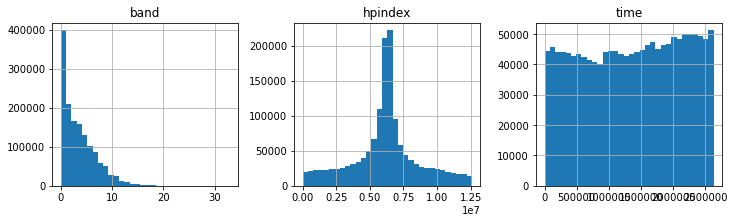

In [ ]:
ft1_file = '/mnt/d/tmp/P305_Source_144_zmax105.fits'
import os
if os.path.exists(ft1_file):
    tstart, df  = convert_FT1(ft1_file, verbose=2)
    df.hist(bins=32, layout=(1,3), figsize=(12,3));